# Chat Intents

## UMAP + Clustering

In [134]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

import umap

In [72]:
from tqdm.notebook import tqdm, trange

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
from sentence_transformers import SentenceTransformer

In [9]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [5]:
model_st1 = SentenceTransformer('paraphrase-mpnet-base-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/594 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')
data_sample.head()

,Unnamed: 0,text,category,cleaned_text
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money


In [8]:
def embed_use(model, sentences):
    return model(sentences)

def embed_st(model, sentences):
    return model.encode(sentences)

In [12]:
embed_use(model_use, [data_sample.loc[0, 'text']]).shape

TensorShape([1, 512])

In [13]:
embed_st(model_st1, [data_sample.loc[0, 'text']]).shape

(1, 768)

In [16]:
all_intents = list(data_sample['text'])
len(all_intents)

1000

## Clustering without dimensionality reduction

### K-means

In [8]:
def plot_kmeans(X, k_range):
    sse = []
    silhouette_avg_n_clusters = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)

        silhouette_avg = silhouette_score(X, kmeans.predict(X))
        silhouette_avg_n_clusters.append(silhouette_avg)


    # plot sse
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(k_range, sse)
    axes[0].set(xlabel = 'k clusters', ylabel = 'SSE', title = 'Elbow plot')
    axes[0].grid()
    
    # plot avg silhouette score
    axes[1].plot(k_range, silhouette_avg_n_clusters)
    axes[1].set(xlabel = 'k clusters', ylabel = 'Silhouette score', title = 'Silhouette score')
    axes[1].grid()

    plt.show()

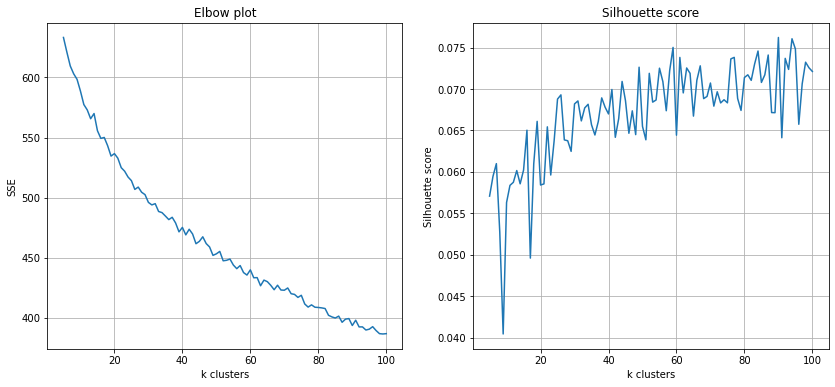

CPU times: user 42.9 s, sys: 1.7 s, total: 44.6 s
Wall time: 14.4 s


In [9]:
%%time

X = intents_embeddings
k_range = range(5, 101)

plot_kmeans(X, k_range)

### DBSCAN

In [10]:
db = DBSCAN(eps=0.25, min_samples=5, metric='cosine').fit(X)
labels = db.labels_
len(np.unique(labels))

21

In [11]:
len(labels)

1000

In [12]:
silhouette_score(X, labels, metric='cosine')

-0.19035175

In [94]:
def plot_dbscan(X, eps_range):
    silhouette_avg_n_clusters = []
    silhouette_avg = -1

    for eps in eps_range:
        db = DBSCAN(eps=eps, min_samples=3, metric='cosine').fit(X)
        labels = db.labels_

        if len(np.unique(labels)) > 1:
            silhouette_avg = silhouette_score(X, labels, metric='cosine')
        else:
            silhouette_av = -1
        silhouette_avg_n_clusters.append(silhouette_avg)

    
    # plot avg silhouette score
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(eps_range, silhouette_avg_n_clusters)
    ax.set(xlabel = 'k clusters', ylabel = 'Silhouette score', title = 'Silhouette score')
    ax.grid()

    plt.show()

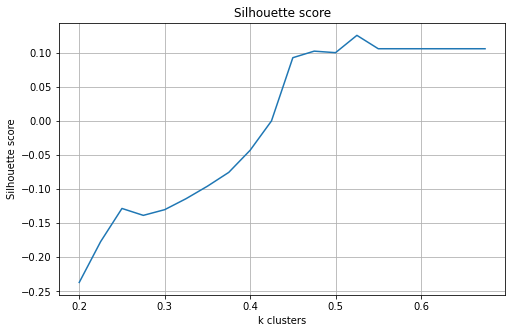

In [95]:
eps_range = np.arange(0.2, 0.7, 0.025)
plot_dbscan(X, eps_range)

In [96]:
db = DBSCAN(eps=0.5, min_samples=3, metric='cosine').fit(X)
labels = db.labels_
len(np.unique(labels))

3

In [97]:
silhouette_score(X, labels, metric='cosine')

0.099877276

### HDBSCAN

In [13]:
X = intents_embeddings
clusters_hdbscan = hdbscan.HDBSCAN(min_cluster_size=2, 
                                   metric='euclidean', 
                                   cluster_selection_method='eom').fit(X)

labels = clusters_hdbscan.labels_
len(np.unique(labels))

204

In [14]:
np.count_nonzero(clusters_hdbscan.probabilities_ < 0.05)

355

## Clustering with dimensionality reduction

In [29]:
def generate_clusters(message_embeddings, n_neighbors = 4, n_components = 5, min_cluster_size = 4):
    umap_embeddings = umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine').fit_transform(message_embeddings)

    cluster = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                              metric='euclidean', 
                              cluster_selection_method='eom').fit(umap_embeddings)
    return cluster

In [59]:
def score_clusters(clusters):
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    score = np.count_nonzero(clusters.probabilities_ < 0.05)
    
    return label_count, score

In [88]:
def scan_hyperparameters(all_intents, n_repeats):
    use_embeddings = embed_use(model_use, all_intents)
    
    results = []
    for n_neighbors in trange(3, 15, desc='n_neighbors'):
        for n_components in trange (3, 8, desc='n_components'):
            for min_cluster_size in trange(2, 10, desc='min_cluster_size'):
                count_sum = 0
                score_sum = 0
    
                for i in range(n_repeats):
                    use_clusters = generate_clusters(use_embeddings, n_neighbors, n_components, min_cluster_size)
                    label_count, score = score_clusters(use_clusters)
                    
                    count_sum += label_count
                    score_sum += score
                    
                avg_label_count = count_sum/n_repeats
                avg_score = score_sum/n_repeats
                results.append([n_neighbors, n_components, min_cluster_size, avg_label_count, avg_score])
    
    result_df = pd.DataFrame(results, columns=['n_neighbors', 'n_components', 'min_cluster_size', 'avg_label_count', 'avg_score'])
    
    return result_df

In [ ]:
%%time
results_use = scan_hyperparameters(all_intents, 3)

In [84]:
results_use

,n_neighbors,n_components,min_cluster_size,avg_label_count,avg_score
0,3,3,2,179,77.4


In [58]:
results_use[(results_use.score < 100)&(results_use.label_count < 100)&(results_use.label_count > 10)]

,n_neighbors,n_components,min_cluster_size,label_count,score
42,3,3,4,85,92
50,3,4,4,81,98
63,3,5,9,27,72
67,3,6,5,60,77


In [60]:
results_use.head()

,n_neighbors,n_components,min_cluster_size,label_count,score
0,2,3,2,201,97
1,2,3,3,147,152
2,2,3,4,104,247
3,2,3,5,87,226
4,2,3,6,70,230


In [71]:
use_embeddings = embed_use(model_use, all_intents)
num = 5
param_dict = [[4, 5, 4], 
              [3, 5, 9], 
              [3, 3, 4], 
              [3, 4, 4], 
              [3, 6, 6]]

for params in param_dict:
    count_sum = 0
    score_sum = 0
    
    for i in range(num):
        clusters = generate_clusters(use_embeddings, 
                                     n_neighbors = params[0], 
                                     n_components = params[1], 
                                     min_cluster_size = params[2])
        
        label_count, score = score_clusters(clusters)

        count_sum += label_count
        score_sum += score

    print(f"Avg number of clusters: {count_sum/num} . Avg score: {score_sum/num}")

Avg number of clusters: 85.8 . Avg score: 130.2
Avg number of clusters: 31.0 . Avg score: 178.6
Avg number of clusters: 86.6 . Avg score: 97.0
Avg number of clusters: 87.4 . Avg score: 104.2
Avg number of clusters: 53.2 . Avg score: 142.4


In [92]:
use_embeddings = embed_use(model_use, all_intents)
clusters = generate_clusters(use_embeddings, n_neighbors = 3, n_components = 3, min_cluster_size = 4)
label_count, score = score_clusters(clusters)
print(label_count)
print(score)

88
125


In [146]:
intents_df_use = pd.DataFrame(all_intents, columns=['message'])
intents_df_use['topic_use'] = clusters.labels_
intents_df_use.head(10)

,message,topic_use
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,64
1,I got charged a fee that shouldn't be there from my cash,79
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,86
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,67
4,Are there ways for other people to send me money?,13
5,How can I receive money?,13
6,where can I change my address?,21
7,What do I do if I still have not received my new card?,74
8,Is there anywhere I can't use my card?,54
9,I want to have multiple currencies in my account if possible.,42


In [140]:
st1_embeddings = embed_st(model_st1, all_intents)
clusters_st1 = generate_clusters(st1_embeddings, n_neighbors = 3, n_components = 3, min_cluster_size = 4)
label_count_st1, score_st1 = score_clusters(clusters_st1)
print(label_count_st1)
print(score_st1)

93
71


## Evaluate clusters

In [158]:
intents_df_st1 = pd.DataFrame(all_intents, columns=['message'])
intents_df_st1['topic_st1'] = clusters_st1.labels_
intents_df_st1.head()

,message,topic_st1
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,18
1,I got charged a fee that shouldn't be there from my cash,-1
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,90
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,74
4,Are there ways for other people to send me money?,40


In [159]:
results_df = pd.merge(intents_df_use, data_sample, left_on = 'message', right_on='text', how = 'left')[['message','topic_use','category']]
results_df = pd.merge(results_df, intents_df_st1, left_on = 'message', right_on='message', how = 'left')
results_df.head(10)

,message,topic_use,category,topic_st1
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,64,card_delivery_estimate,18
1,I got charged a fee that shouldn't be there from my cash,79,cash_withdrawal_charge,-1
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,86,cash_withdrawal_charge,90
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,67,balance_not_updated_after_cheque_or_cash_deposit,74
4,Are there ways for other people to send me money?,13,receiving_money,40
5,How can I receive money?,13,receiving_money,40
6,where can I change my address?,21,edit_personal_details,35
7,What do I do if I still have not received my new card?,74,card_arrival,18
8,Is there anywhere I can't use my card?,54,card_acceptance,10
9,I want to have multiple currencies in my account if possible.,42,fiat_currency_support,4


In [162]:
results_df[results_df['topic_use']==2]

,message,topic_use,category,topic_st1
441,My card is almost expired. How fast will I get a new one and what is the cost?,2,card_about_to_expire,42
477,My card is about to expire. Do I have to go to a branch to order a new card?,2,card_about_to_expire,42
521,"My card expires soon, will you send me one automatically?",2,card_about_to_expire,42
524,My card expires very soon. What is the cost and delivery time to get a new one?,2,card_about_to_expire,42
584,How do I get a new expiration date?,2,card_about_to_expire,42
646,My card is almost going to expire.,2,card_about_to_expire,42
765,My card expires soon,2,card_about_to_expire,42
812,What is the cost and time frame of getting a new card?,2,card_about_to_expire,42
833,Help me order a new card that's going to be expired soon.,2,card_about_to_expire,42
888,What happens if my card expires?,2,card_about_to_expire,42


In [163]:
results_df[results_df['category']=='card_about_to_expire']

,message,topic_use,category,topic_st1
27,"I am overseas in China, can I get a replacement card?",44,card_about_to_expire,0
370,"If I am in China, can I still order a new card and if so, how?",44,card_about_to_expire,0
441,My card is almost expired. How fast will I get a new one and what is the cost?,2,card_about_to_expire,42
477,My card is about to expire. Do I have to go to a branch to order a new card?,2,card_about_to_expire,42
521,"My card expires soon, will you send me one automatically?",2,card_about_to_expire,42
524,My card expires very soon. What is the cost and delivery time to get a new one?,2,card_about_to_expire,42
551,Where can I have a new bank card sent to China?,44,card_about_to_expire,0
584,How do I get a new expiration date?,2,card_about_to_expire,42
605,Are there any express fees if i want my new card faster?,-1,card_about_to_expire,42
646,My card is almost going to expire.,2,card_about_to_expire,42


In [126]:
results_df[results_df['topic']==44]

,message,topic,category
27,"I am overseas in China, can I get a replacement card?",44,card_about_to_expire
370,"If I am in China, can I still order a new card and if so, how?",44,card_about_to_expire
381,Where is the PIN for my card located?,44,get_physical_card
420,Where do I find my PIN for my new card?,44,get_physical_card
450,Where can I get my card PIN?,44,get_physical_card
551,Where can I have a new bank card sent to China?,44,card_about_to_expire
627,When do I get my card PIN?,44,get_physical_card
918,"In the app, where do I find my card PIN?",44,get_physical_card


In [128]:
data_sample[data_sample['category']=='get_physical_card']

,Unnamed: 0,text,category,cleaned_text
269,4038,How do I request the PIN?,get_physical_card,request pin
381,4026,Where is the PIN for my card located?,get_physical_card,pin card located
417,4005,My pin isn't here yet,get_physical_card,pin isnt yet
420,4096,Where do I find my PIN for my new card?,get_physical_card,find pin new card
450,3996,Where can I get my card PIN?,get_physical_card,get card pin
510,4044,Where's my card PIN?,get_physical_card,wheres card pin
560,4045,How do I set my physical card PIN?,get_physical_card,set physical card pin
583,3994,"I'm not sure what to do about the PIN, because I don't have one yet.",get_physical_card,im sure pin dont one yet
627,4084,When do I get my card PIN?,get_physical_card,get card pin
844,4046,wheres my pin,get_physical_card,wheres pin


In [165]:
nmi_use = normalized_mutual_info_score(results_df['category'].values, results_df['topic_use'].values)
nmi_st1 = normalized_mutual_info_score(results_df['category'].values, results_df['topic_st1'].values)
print(f"NMI for USE embedding: {nmi_use}")
print(f"NMI for Sent-transformer 1 embedding: {nmi_st1}")

NMI for USE embedding: 0.7173797693365336
NMI for Sent-transformer 1 embedding: 0.7801523881618632


In [167]:
ari_use = adjusted_rand_score(results_df['category'].values, results_df['topic_use'].values)
ari_st1 = adjusted_rand_score(results_df['category'].values, results_df['topic_st1'].values)
print(f"ARI for USE embedding: {ari_use}")
print(f"ARI for Sent-transformer 1 embedding: {ari_st1}")

ARI for USE embedding: 0.23851974666661185
ARI for Sent-transformer 1 embedding: 0.3862417266135025


## Visualize clusters

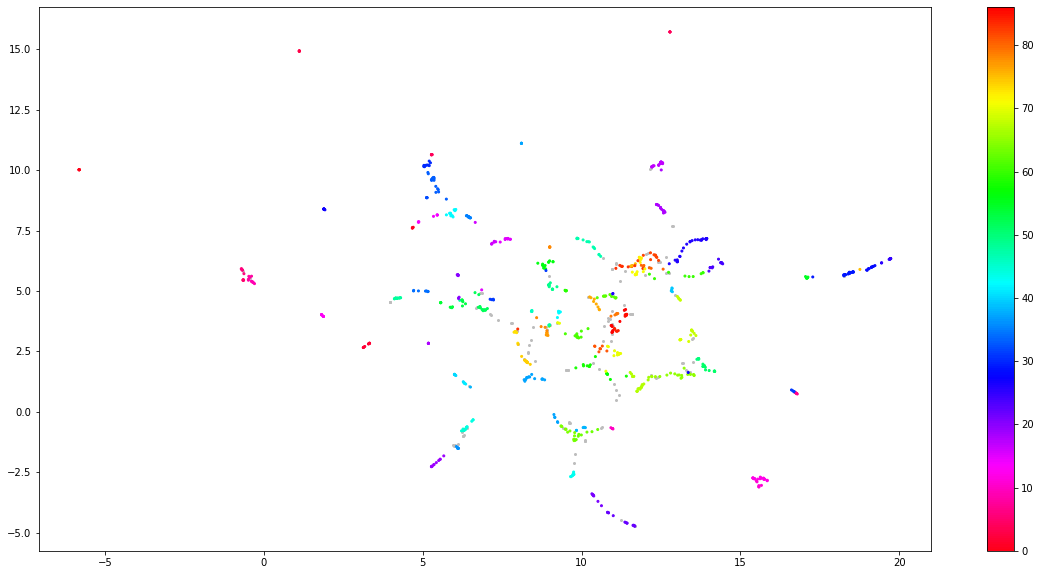

In [168]:
umap_data = umap.UMAP(n_neighbors=4, 
                      n_components=2, 
                      min_dist = 0.0, 
                      metric='cosine').fit_transform(use_embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clusters.labels_

fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color = '#BDBDBD', s=4)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=4, cmap='hsv_r')
plt.colorbar()